<a href="https://colab.research.google.com/github/ryane-jon/Natural-Language-Processing-Coursework/blob/main/NLP_Coursework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Language Proccessing (CE4145) Coursework
- Ryan Jones (2208751)
- Dataset Source: [Sentiment Labelled Sentences](https://archive.ics.uci.edu/dataset/331/sentiment+labelled+sentences)

This dataset consists of:
- **Sentences:** in the form of reviews sourced from Amazon, IMDB and Yelp.
- **Sentiments:** represented as 1s for positive, and 0s for negative.  
- **Sources:** as seperate files; Each file is data from a different source, each with 1000 different sentences.

Tasks:
- Create a model that can predict the sentiment (Positive or Negative) of various sentences.
- I also plan to extend this to detect the source of these sentences (Amazon, imdb or yelp)

# Dataset & Pre-Processing

## Import dataset
(from the download of the dataset in the provided link)

The 3 files are imported (amazon_cells_labelled.txt, imdb_labelled.txt, yelp_labelled.txt)

In [1]:
#used to upload data
import io
from google.colab import files
uploaded = files.upload() #files can be uploaded here, I select the 3 labelled files.

Saving amazon_cells_labelled.txt to amazon_cells_labelled.txt
Saving imdb_labelled.txt to imdb_labelled.txt
Saving yelp_labelled.txt to yelp_labelled.txt


In [2]:
#import stuff to use later
from sklearn.pipeline import Pipeline #let's import the pipeline functionality
from sklearn.feature_extraction.text import CountVectorizer #and we will import a simple pre-processing method
from sklearn.feature_extraction.text import TfidfTransformer #and a representation learner
from sklearn.neighbors import KNeighborsClassifier #and a simple classifier model
from sklearn.model_selection import StratifiedKFold #cross fold is sometimes called k-fold. Calling the stratified version ensures that classes have equal representation across folds
from sklearn.metrics import accuracy_score #import an accuracy metric to tell us how well the model is doing

Split each files lines into strings in arrays to be processed

In [3]:
amazon_data = uploaded['amazon_cells_labelled.txt'].decode('UTF-8').splitlines()
imdb_data = uploaded['imdb_labelled.txt'].decode('UTF-8').splitlines()
yelp_data = uploaded['yelp_labelled.txt'].decode('UTF-8').splitlines()

#View some of the data
for index in range(5):
  print(amazon_data[index])
  print(imdb_data[index])
  print(yelp_data[index])

So there is no way for me to plug it in here in the US unless I go by a converter.	0
A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  	0
Wow... Loved this place.	1
Good case, Excellent value.	1
Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  	0
Crust is not good.	0
Great for the jawbone.	1
Attempting artiness with black & white and clever camera angles, the movie disappointed - became even more ridiculous - as the acting was poor and the plot and lines almost non-existent.  	0
Not tasty and the texture was just nasty.	0
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!	0
Very little music or anything to speak of.  	0
Stopped by during the late May bank holiday off Rick Steve recommendation and loved it.	1
The mic is great.	1
The best scene in the movie was when Gerardo is trying to find a song that keeps running through his head.  	1
The selection on the menu was great

Create a numpy array with 3 collumns: Review, Sentiment, and Source

In [4]:
import numpy as np
reviews = []
sentiments = []
sources = []



for line in amazon_data:
  reviews.append(line[:-1])
  sentiments.append(line[-1])
  sources.append("Amazon")

for line in imdb_data:
  reviews.append(line[:-1])
  sentiments.append(line[-1])
  sources.append("IMDB")

for line in yelp_data:
  reviews.append(line[:-1])
  sentiments.append(line[-1])
  sources.append("Yelp")


data = np.column_stack((reviews, sentiments, sources))
print(data.shape)

(3002, 3)


## Validate Imported Data

In [5]:
#Checks through the sentiment values to make sure they're all 0 or 1
def checkSentimentValid(datas, print_info=False): #datas is the numpy array, print_info turns on printing info
  x,y,z = datas.T
  markedForDeath = [] #contains bad eggs
  count = 0
  for sentiment in y: #for each sentiment value
    if sentiment != "0" and sentiment != "1": # make sure it's "0" or "1", if not, get as relevant surrounding info
      markedForDeath.append(count)  #an omen
      if print_info:    #print as much context as possible
        print(str(count))
        print(x[count]+"\t"+y[count]+"\t"+z[count])
        print(x[count+1]+"\t"+y[count+1]+"\t"+z[count+1]+"\n")
    count= count+1
  if print_info and len(markedForDeath)==0:
    print("No bad eggs found")
  return markedForDeath

checkSentimentValid(data, True)


1178
The script i	s	IMDB
was there a script?  		0	IMDB

1968
Definitely worth seein	g	IMDB
 it's the sort of thought provoking film that forces you to question your own threshold of loneliness.  		1	IMDB



[1178, 1968]

This is a result of some reviews containing a character that is misinterpereted as a new line, splitting the review in two. With this knowledge, I can fix these values.

In [6]:
marked = checkSentimentValid(data) #store the bad eggs
marked.sort(reverse=True) #Sorted in reverse so I can pop one data without changing the index of the other
for marker in marked:
  if sentiments[marker] != "0" and sentiments[marker] != "1": #Ensure the data is bad (in case I accidentally run this block again)
    reviews[marker+1] = reviews[marker] + sentiments[marker]+" " + reviews[1969] #rejoin the split review as one
    reviews.pop(marker) #remove the leftover data
    sentiments.pop(marker)
    sources.pop(marker)

data = np.column_stack((reviews, sentiments, sources))  #redefine data

should now be no issue

In [7]:
checkSentimentValid(data, True)

No bad eggs found


[]

## Create Final np Array

In [8]:
random_array = []
for i in range(len(reviews)):
  random_array.append(i)
np.random.shuffle(random_array)

shuffled_reviews = []
shuffled_sentiments = []
shuffled_sources = []

for i in random_array:
  shuffled_reviews.append(reviews[i])
  shuffled_sentiments.append(sentiments[i])
  shuffled_sources.append(sources[i])

data = np.column_stack((shuffled_reviews, shuffled_sentiments, shuffled_sources))

## Test Prep in NLP Pipeline.
- To start with, it's just predicting the sentiment based on the review text, I will bring the source in (possibly as an additional feature or as a target).
- **This section is mostly me testing some pre-proccessing and tokenization methods to see what is actually helpful**

In [33]:
x, y, z = data.T  #x=reviews, y=sentiment, z=source
text_clf = Pipeline([ #Pipeline to organise functions
  ('prep', CountVectorizer()), #Count vectorizer
  ('rep', TfidfTransformer()), #representation learning method using tf-idf
  ('mod', KNeighborsClassifier()), #kNN classifier
  ])

acc_score = []

kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(x,y):
  x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]
  text_clf.fit(x_train, y_train) #fit to training data
  predictions = text_clf.predict(x_test) #predict on test data
  acc_score.append(accuracy_score(predictions, y_test)) #get accuracy

print("Accuracy:", np.mean(acc_score)) #mean accuracy


Accuracy: 0.7723333333333333


Double-checking that data is being represented correctly

In [34]:
for index in range(0,4):
  print(x[index*100])
  print(y[index*100])
  print(z[index*100])

However, there was so much garlic in the fondue, it was barely edible.	
0
Yelp
The WORST EXPERIENCE EVER.	
0
Yelp
The shrimp tender and moist.	
1
Yelp
It was a great phone.	
1
Amazon


### Introduce tokenization and more pre-proccessing techniques into the pipeline

Import packages for tokenization

In [35]:
import nltk #import the natural language toolkit

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Create a new tokenize function and add it to the pipeline

In [36]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
class pre_process_tokenize(BaseEstimator, TransformerMixin):

    def __init__(self):
      return None

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
      prep_text = []
      for x in X:
            #basic tokenisation
            token_text = word_tokenize(x)
            #lower casing & punctiuation removal)
            normd_text = [token.lower() for token in token_text]
            #stopword removal
            swr_text = [token for token in normd_text if token not in stopwords.words('english')] #list compression to remove any stopwords from our list
            #stemming
            stemmer = SnowballStemmer("english") #specify we are using the English stemming rules, as other languages are present in toolkit
            prep_text += [[stemmer.stem(word) for word in swr_text]] #list compression for applying the stemmer

      #rejoin the sentences
      prep_sentences = [" ".join(sentence) for sentence in prep_text]
      return prep_sentences

text_clf = Pipeline([
  ('prep', pre_process_tokenize()),
  ('rep', TfidfVectorizer()),
  ('mod', KNeighborsClassifier()),
  ])


acc_score = []

kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(x,y):

  x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]

  text_clf.fit(x_train, y_train)
  predictions = text_clf.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  acc_score.append(acc)

print("Accuracy:", np.mean(acc_score))

Accuracy: 0.7396666666666667


This has decreased the overall accuracy.
- It's possible that stemming and stop word removal caused context and nuance to be lost, which was made worse by the fact that the each data point is only a single sentence, coming from multiple different sources.
- I.E Without the source to contextualise the review, the feature starts to lose some important meaning.
- Additionally, punctiuation and capitilisation could be very important for determining sentiment. E.g. "No. Price too high!" vs "no price too high", or the one about uncle jack and the horse.



- Upon testing various combinations of pre-proccessing techniques, the only one that improved accuracy from the base NLP pipeline was **negation handling**
- The other techniques would probably work a lot better if the data points were more than just one sentence, but as it stands every bit of context is important for determining sentiment. That is why the prep function probably won't be incredibly complex.

## Create final prep function

Only includes basic tokenisation and negation handling

In [63]:
import string

def prep(X):
  #define negation words (I used a lil AI for this bit)
  negation_words = {"not", "no", "never", "n't", "don't", "won't", "can't", "isn't", "aren't", "wasn't", "weren't", "haven't", "hasn't", "hadn't", "doesn't", "didn't", "couldn't", "shouldn't", "wouldn't", "hardly", "barely", "scarcely", "seldom"}
  punctuation_marks = set(string.punctuation)

  prep_text = []
  for x in X:
        token_text = word_tokenize(x) #basic tokenization
        processed_tokens = [] #used to store new tokens post-negation-handling
        negation_active = False #used to tell us if the last word was a negation word, false to start with

        for token in token_text:
            normalized_token = token.lower()  #normalise the tokens to compare to the negation words

            if normalized_token in negation_words:      #if token is a negation word (not, never etc)
                negation_active = True                    #set negation to true for the next word
                processed_tokens.append(token)            #append unchanged token
            elif normalized_token in punctuation_marks: #if token is a punctuation mark (i.e a seperator of ideas)
                negation_active = False                   #set negation to false
                processed_tokens.append(token)            #append unchanged token
            elif negation_active:                       #if the last word was a negation word
                processed_tokens.append(token + '_NEG')   #append with a negation identifier
            else:                                       #if it's just a normal word
                processed_tokens.append(token)            #append unchanged token
        prep_text.append(processed_tokens)

  #rejoin the sentences
  prep_sentences = [" ".join(sentence) for sentence in prep_text]
  return prep_sentences

class prep_func(BaseEstimator, TransformerMixin): # Version of the prep function to use in pipeline

    def __init__(self):
      return None

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
      return prep(X)  #uses the prep function above

# Representation Learning

## Possible techniques to use
- Word2Vec
  - Representation of contextual knowledge would be very helpful considering textual context has proven to be very important for this model.
- Tfidf
  - I could add n-grams to the rep I used in the test pipeline to make it more effective. Although, since I already added negation handling, N-grams may not make much difference.
- Doc2Vec
  - Representation of an entire sentence could catch a lot of nuance and context that would be missed by a word-by-word representation, it could take the workload off of the final algorithm. However, this depends on how accurate it is compared to the final applied algorithm.


Upon testing, Word2Vec and Doc2Vec both ended up less accurate than Tfidf with both kNN (<60%) and MLP (<70%). They probably need a much larger dataset to learn details, my dataset of 3000 sentences might not be enough. Additionally, N-grams yielded a worse accuracy with kNN, but I expect that they would be useful for a more complex algorithm like MLP.

# Algorithms


## Algorithms Being Tested
- k-Nearest Neighbour - This is the one I have been using to test prep & rep thus far.
- Multi-Layer Perceptron - This is more complex and uses a neural network, therefore n-grams will probably be more effective for this algorithm. This algorithm will also probably be **more accurate** for this data.
- Desicion Tree - Will be prone to overfitting, it will probably **perform similarly to kNN**, but more data is more. I leave power, good.
## Targets
- I will test both sentiments and sources, to compare how accurate this model is for predicting things other than sentiment.

### Sentiment

In [64]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

knn_pipeline = Pipeline([
  ('prep', prep_func()),
  ('rep', TfidfVectorizer()),
  ('mod', KNeighborsClassifier()),
  ])

mlp_pipeline = Pipeline([
  ('prep', prep_func()),
  ('rep', TfidfVectorizer(ngram_range=(1,2))),
  ('mod', MLPClassifier()),
  ])

dt_pipeline = Pipeline([
  ('prep', prep_func()),
  ('rep', TfidfVectorizer()),
  ('mod', DecisionTreeClassifier()),
  ])


knn_score = []
mlp_score = []
dt_score = []

kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(x,y):

  x_train, x_test, y_train, y_test = x[train], x[test], y[train], y[test]

  knn_pipeline.fit(x_train, y_train)
  predictions = knn_pipeline.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  knn_score.append(acc)

  mlp_pipeline.fit(x_train, y_train)
  predictions = mlp_pipeline.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  mlp_score.append(acc)

  dt_pipeline.fit(x_train, y_train)
  predictions = dt_pipeline.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  dt_score.append(acc)

print("kNN Accuracy: ", np.mean(knn_score))
print("MLP Accuracy: ", np.mean(mlp_score))
print("DT Accuracy: ", np.mean(dt_score))


kNN Accuracy:  0.7956666666666667
MLP Accuracy:  0.8320000000000001
DT Accuracy:  0.7146666666666667


### Source

In [71]:
source_knn_score = []
source_mlp_score = []
source_dt_score = []

kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(x,z):

  x_train, x_test, y_train, y_test = x[train], x[test], z[train], z[test]

  knn_pipeline.fit(x_train, y_train)
  predictions = knn_pipeline.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  source_knn_score.append(acc)

  mlp_pipeline.fit(x_train, y_train)
  predictions = mlp_pipeline.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  source_mlp_score.append(acc)

  dt_pipeline.fit(x_train, y_train)
  predictions = dt_pipeline.predict(x_test)
  acc = accuracy_score(predictions, y_test)
  source_dt_score.append(acc)

print("kNN Accuracy: ", np.mean(source_knn_score))
print("MLP Accuracy: ", np.mean(source_mlp_score))
print("DT Accuracy: ", np.mean(source_dt_score))

kNN Accuracy:  0.734
MLP Accuracy:  0.8416666666666666
DT Accuracy:  0.6376666666666667


# Evaluation

[Text(1, 0, 'kNN'), Text(2, 0, 'MLP'), Text(3, 0, 'Tree')]

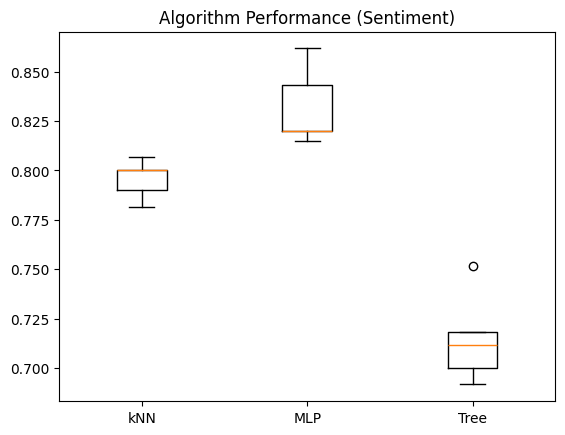

In [73]:
import matplotlib as plt

acc_scores = []
acc_scores.append(knn_score)
acc_scores.append(mlp_score)
acc_scores.append(dt_score)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm Performance (Sentiment)')
ax2.boxplot(acc_scores)
ax2.set_xticklabels(['kNN', 'MLP', 'Tree'], rotation='horizontal')

[Text(1, 0, 'kNN'), Text(2, 0, 'MLP'), Text(3, 0, 'Tree')]

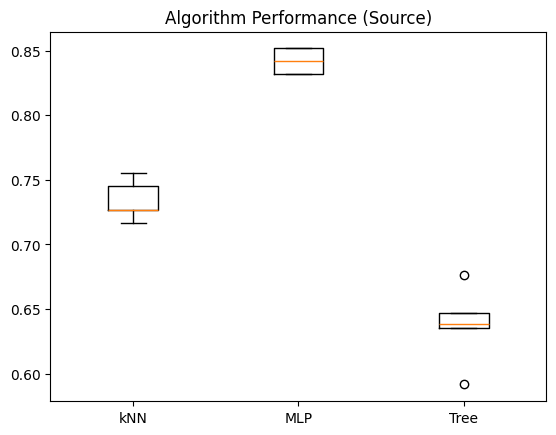

In [72]:
import matplotlib as plt

acc_scores = []
acc_scores.append(source_knn_score)
acc_scores.append(source_mlp_score)
acc_scores.append(source_dt_score)

fig, ax2 = plt.pyplot.subplots()
ax2.set_title('Algorithm Performance (Source)')
ax2.boxplot(acc_scores)
ax2.set_xticklabels(['kNN', 'MLP', 'Tree'], rotation='horizontal')

## Algorithm Comparison

The results clearly show than MLP outperforms kNN and Desicion Tree. Furthermore, desicion tree was terrible in this situation. This suggests that Multi-Layer Perceptron is appropriate for this type of problem. It may be beneficial to test Doc2Vec in combination with different pre-proccessing techniques.

## Different Target Evaluation (Comparing Source vs. Sentiment prediction)

- On average, MLP was shown to be slightly more accurate when it comes to sources, but kNN and desicion tree were shown to be less accurate.
- All of the results are more consistent for source, and it should be noted that the testing for Sentiment MLP still had a higher maximum, and that other (less consistent) results brought the average down.
- Negation handling is probably less useful when it comes to predicting the source, as specific words are just more common. Something like MLP would probably be more likely to pick up on this.
- Pre-proccessing techniques that didn't help with sentiment would be useful for source, like stemming or lemmitization.